In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
import skimage
from multiprocessing import Pool
from progressbar import progressbar as pb
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.backends.backend_pdf import PdfPages

torch.cuda.get_device_name(0)

'Tesla M60'

%%javascript
$('.nbp-app-bar').toggle()

In [2]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [3]:
train_inds = list(np.random.choice(np.arange(50000), 5000))
test_inds = list(np.random.choice(np.arange(10000), 500))

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=preprocess)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, 
                                          num_workers=0, sampler=SequentialSampler(train_inds))

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=preprocess)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         num_workers=0, sampler=SequentialSampler(test_inds))

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class VGG2(nn.Module):
    def __init__(self, batchnorm=False):
        super(VGG2, self).__init__()
        self.batchnorm = batchnorm
        
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1_1 = nn.Conv2d(3, 64, 3, 1)

        self.conv2_1 = nn.Conv2d(64, 128, 3, 1)

        self.conv3_1 = nn.Conv2d(128, 256, 3, 1)
        self.conv3_2 = nn.Conv2d(256, 256, 3, 1)

        self.conv4_1 = nn.Conv2d(256, 512, 3, 1)
        self.conv4_2 = nn.Conv2d(512, 512, 3, 1)

        self.conv5_1 = nn.Conv2d(512, 512, 3, 1)
        self.conv5_2 = nn.Conv2d(512, 512, 3, 1)

        self.fc1 = nn.Linear(4608, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.out = nn.Linear(4096, 10)

        if self.batchnorm:
            self.bn1 = nn.BatchNorm2d(64)
            self.bn2 = nn.BatchNorm2d(128)
            self.bn3 = nn.BatchNorm2d(256)
            self.bn4 = nn.BatchNorm2d(512)
            self.bn5 = nn.BatchNorm1d(4096)
            
    def forward(self, x):
        if not self.batchnorm:
            x = F.relu(self.conv1_1(x))
            x = self.pool(x)

            x = F.relu(self.conv2_1(x))
            x = self.pool(x)

            x = F.relu(self.conv3_1(x))
            x = F.relu(self.conv3_2(x))
            x = self.pool(x)

            x = F.relu(self.conv4_1(x))
            x = F.relu(self.conv4_2(x))
            x = self.pool(x)

            x = F.relu(self.conv5_1(x))
            x = F.relu(self.conv5_2(x))
            x = self.pool(x)
            x = x.view(x.shape[0], -1)

            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.out(x)
            #x = nn.Softmax(x)
        else:
            x = F.relu(self.bn1(self.conv1_1(x)))
            x = self.pool(x)

            x = F.relu(self.bn2(self.conv2_1(x)))
            x = self.pool(x)

            x = F.relu(self.bn3(self.conv3_1(x)))
            x = F.relu(self.bn3(self.conv3_2(x)))
            x = self.pool(x)

            x = F.relu(self.bn4(self.conv4_1(x)))
            x = F.relu(self.bn4(self.conv4_2(x)))
            x = self.pool(x)

            x = F.relu(self.bn4(self.conv5_1(x)))
            x = F.relu(self.bn4(self.conv5_2(x)))
            x = self.pool(x)
            x = x.view(x.shape[0], -1)

            x = F.relu(self.bn5(self.fc1(x)))
            x = F.relu(self.bn5(self.fc2(x)))
            x = self.out(x)
        
        return x

In [6]:
def train(model, train_loader, optimizer):
    grads = torch.Tensor().cuda()
    model.train()
    for i, batch in enumerate(pb(train_loader)):
        X_batch, y_batch = batch
        X_batch = X_batch.type(torch.cuda.FloatTensor)
        y_batch = y_batch.type(torch.cuda.LongTensor)

        optimizer.zero_grad()

        y_pred = model(X_batch)
        y_pred.retain_grad()
            
        loss = loss_fn(y_pred, y_batch)
        
        max_ind = y_pred.max(1, keepdim=True)[1]
        target_matches = torch.eq(max_ind, y_batch.data.view(len(y_batch), 1))
        accuracy = torch.sum(target_matches).cpu().numpy() / len(y_batch)
        
        loss.backward()
        optimizer.step()
        
        grads = torch.cat((grads,y_pred.grad))
    
    mean_grad = torch.mean(grads, 0)
    return mean_grad

Epoch: 21, BN=True


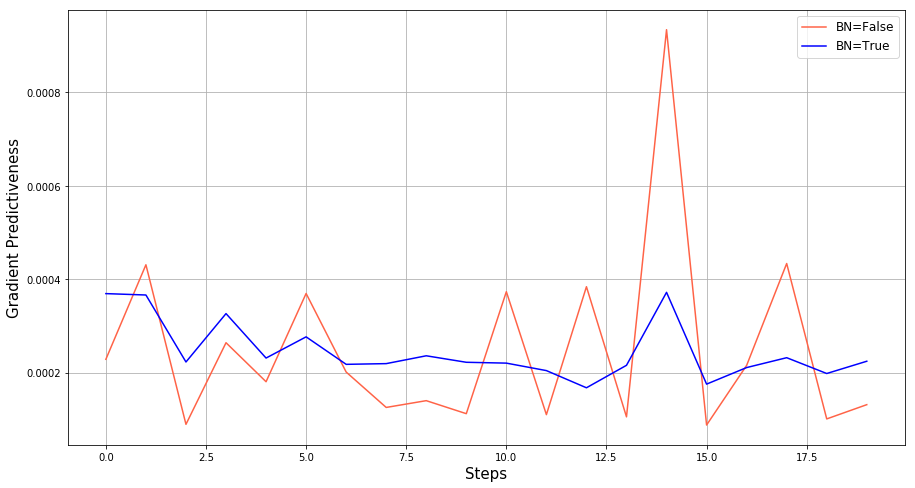

100% (21 of 21) |########################| Elapsed Time: 0:24:51 Time:  0:24:51


In [7]:
train_orig_grad = {False: [], True: []}
train_norms = {False: [], True: []}
lr_vals = np.random.uniform(0.5,4, 21) * 0.1

batch_flag = [False, True]

for flag in batch_flag:
    net = VGG2(flag)
    net.cuda()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
    started = False

    for epoch in pb(range(21)):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_vals[epoch]
        cur_train = train(net, trainloader, optimizer)
        if not started:
            train_orig_grad[flag].append(cur_train)
            started = True
        else:
            train_norms[flag].append(torch.dist(cur_train, train_orig_grad[flag][0]))
            
            clear_output()
            print('Epoch: {}, BN={}'.format(epoch+1, flag))

            f = plt.figure(figsize=(15,8))

            plt.plot(train_norms[False], color='tomato', label='BN={}'.format(False))
            plt.plot(train_norms[True], color='blue', label='BN={}'.format(True))
            plt.grid()
            plt.legend(fontsize=12)
            plt.ylabel('Gradient Predictiveness', size=15)
            plt.xlabel('Steps', size=15)
            pp = PdfPages('Exp42_2.pdf')
            pp.savefig(f)
            pp.close()
            f.savefig('Exp42_2.png')
            plt.show()

In [14]:
print('Without BatchNorm variance: {0:.15f}'.format(np.var(train_norms[False])))
print('With BatchNorm variance:    {0:.15f}'.format(np.var(train_norms[True])))

Without BatchNorm variance: 0.000000038346140
With BatchNorm variance:    0.000000003723067
